In [13]:
import script_utils as utils

MODEL = "custom-2"

tasks = utils.get_tasks(MODEL, remove_corrupted=True)

2026-01-25 22:17:35.543 | WARNING  | script_utils:get_tasks:70 - Warning: Only 337 tasks found, but 352 expected from ground truth.


Total success rate: 84.87% (286/337)


,success_rate_%
domain,
os,95.454545
vs_code,95.454545
chrome,93.181818
vlc,87.500000
libreoffice_calc,86.666667
libreoffice_impress,84.782609
multi_apps,79.518072
thunderbird,78.571429
libreoffice_writer,77.272727


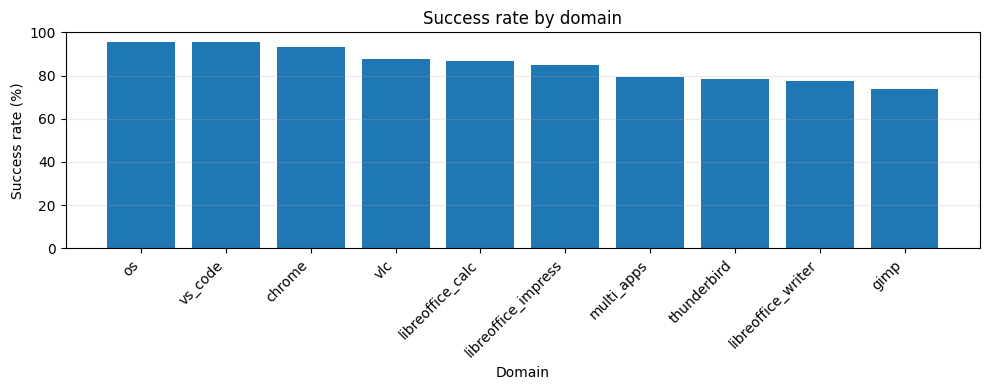

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(tasks).copy()
if df.empty:
    raise ValueError("No tasks found — run Cell 3 first.")

if "domain" not in df.columns or "success" not in df.columns:
    raise ValueError(f"Expected columns ['domain', 'success'] but got: {list(df.columns)}")

df["success_bool"] = df["success"].astype(bool)

# Total success rate (%)
total_success_rate = df["success_bool"].mean() * 100
print(f"Total success rate: {total_success_rate:.2f}% ({df['success_bool'].sum()}/{len(df)})")

# Success rate (%) by domain
success_rate = (
    df.groupby("domain")["success_bool"]
      .mean()
      .mul(100)
      .sort_values(ascending=False)
)

display(success_rate.rename("success_rate_%").to_frame())

plt.figure(figsize=(10, 4))
plt.bar(success_rate.index.astype(str), success_rate.values)
plt.ylabel("Success rate (%)")
plt.xlabel("Domain")
plt.ylim(0, 100)
plt.title("Success rate by domain")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()